## Clustering Statistics

This notebook demonstrates how to calculate the 2-point clustering statistics from DESI data. To generate the window power spectrum, the following are required:
- Number of random mocks: ELG: 10; LRG: 8 ;QSO: 4 (clustering.ran.fits)
- One data file. (clustering.dat.fits)

This notebook also provides how to train the emulators and use the profiler. 

The power spectrum is calculated with`compute_pk.sh`, using the `cosmodesi` environment and the `pkrun.py` to compute the power spectrum.

In [1]:
# loading the desilike enviroment
import os
import glob
import numpy as np
from matplotlib import pyplot as plt

from cosmoprimo.fiducial import DESI
from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, ShapeFitPowerSpectrumTemplate, StandardPowerSpectrumTemplate
from desilike.theories.galaxy_clustering import FOLPSTracerPowerSpectrumMultipoles, FOLPSRCTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike import plotting
from desilike import setup_logging
setup_logging()

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 14
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

2024-10-22 20:10:38.761503: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
# vairables for pk calculation
No = 0
zmin = 0.8  # low_z[0.8,1.1], high_z:[1.1, 1.6]
zmax = 1.1   
zeff = 0.95 # low_zeff:0.98, high_zeff:1.325
tracer = "ELG_LOPnotqso" 
ran_mock_num = "10" # ELG:10; LRG:8; QSO:4
region = "SGC"  # NGC or SGC

# data_fn = os.path.join(os.environ['SCRATCH'], f"./altml{No}/mock{No}/")
pk_dir = os.path.join(os.environ['SCRATCH'], f"altml{No}/data{No}/pk/")
# pk_dir = os.path.join(os.environ['HOME'], "project_rc/main/data/pk/")
output_dir = '/global/homes/s/shengyu/project_rc/main/results'
cov_dir = '/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/'

# load the pk file, the pk calculated from the pkrun.py
pk_fn = pk_dir+f'pkpoles_{tracer}_{region}_{zmin}_{zmax}_default_FKP_lin_thetacut0.05.npy'
wmatrix_fn = pk_dir+f'wmatrix_smooth_{tracer}_{region}_{zmin}_{zmax}_default_FKP_lin_thetacut0.05.npy'

# load the covariance matrix from the Ezmocks
cov_fns = []
cov_fn = f'pkpoles_ELG_LOP_{region}_z{zmin}-{zmax}_default_FKP_lin_nran10_cellsize6_boxsize9000.npy'
for i in range(100, 200):
    mock_dir = f'mock{i}/pk/'
    cov_fns.extend(glob.glob(os.path.join(cov_dir,  mock_dir, cov_fn), recursive=True))

In [3]:
# set the k bins
kmin     = 0.02
kmax     = 0.205
binning  = 0.005
k_ev     = np.arange(kmin, kmax, binning)
klen     = len(k_ev)
klim     = {ell*2: (kmin,kmax,binning) for ell in range(2)}
print(k_ev)

cosmo = DESI()
template = DirectPowerSpectrumTemplate(z=zeff,fiducial='DESI')
theory = FOLPSRCTracerPowerSpectrumMultipoles(template=template)
print(theory.varied_params)
observable = TracerPowerSpectrumMultipolesObservable(data= pk_fn, 
                                                     klim=klim, 
                                                     covariance = cov_fns,
                                                     theory=theory,
                                                     kin=np.arange(0.001, 0.35, 0.002),
                                                     wmatrix=wmatrix_fn)
likelihood = ObservablesGaussianLikelihood(observable)
likelihood()

[0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055 0.06  0.065 0.07  0.075
 0.08  0.085 0.09  0.095 0.1   0.105 0.11  0.115 0.12  0.125 0.13  0.135
 0.14  0.145 0.15  0.155 0.16  0.165 0.17  0.175 0.18  0.185 0.19  0.195
 0.2  ]


ParameterCollection(['h', 'omega_cdm', 'omega_b', 'logA', 'b1', 'b2', 'bs', 'alpha0', 'alpha2', 'alpha4', 'sn0', 'sn2', 'fc'])
[000003.28] [0/1] 10-22 20:10  TracerPowerSpectrumMultipolesObservable INFO     Loading 1 file ['/pscratch/sd/s/shengyu/altml0/data0/pk/pkpoles_ELG_LOPnotqso_NGC_0.8_1.1_default_FKP_lin_thetacut0.05.npy'].
[000003.33] [0/1] 10-22 20:10  TracerPowerSpectrumMultipolesObservable INFO     Loading 100 files [/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock100/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock120/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock140/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/c

Array(-1995.81654106, dtype=float64)

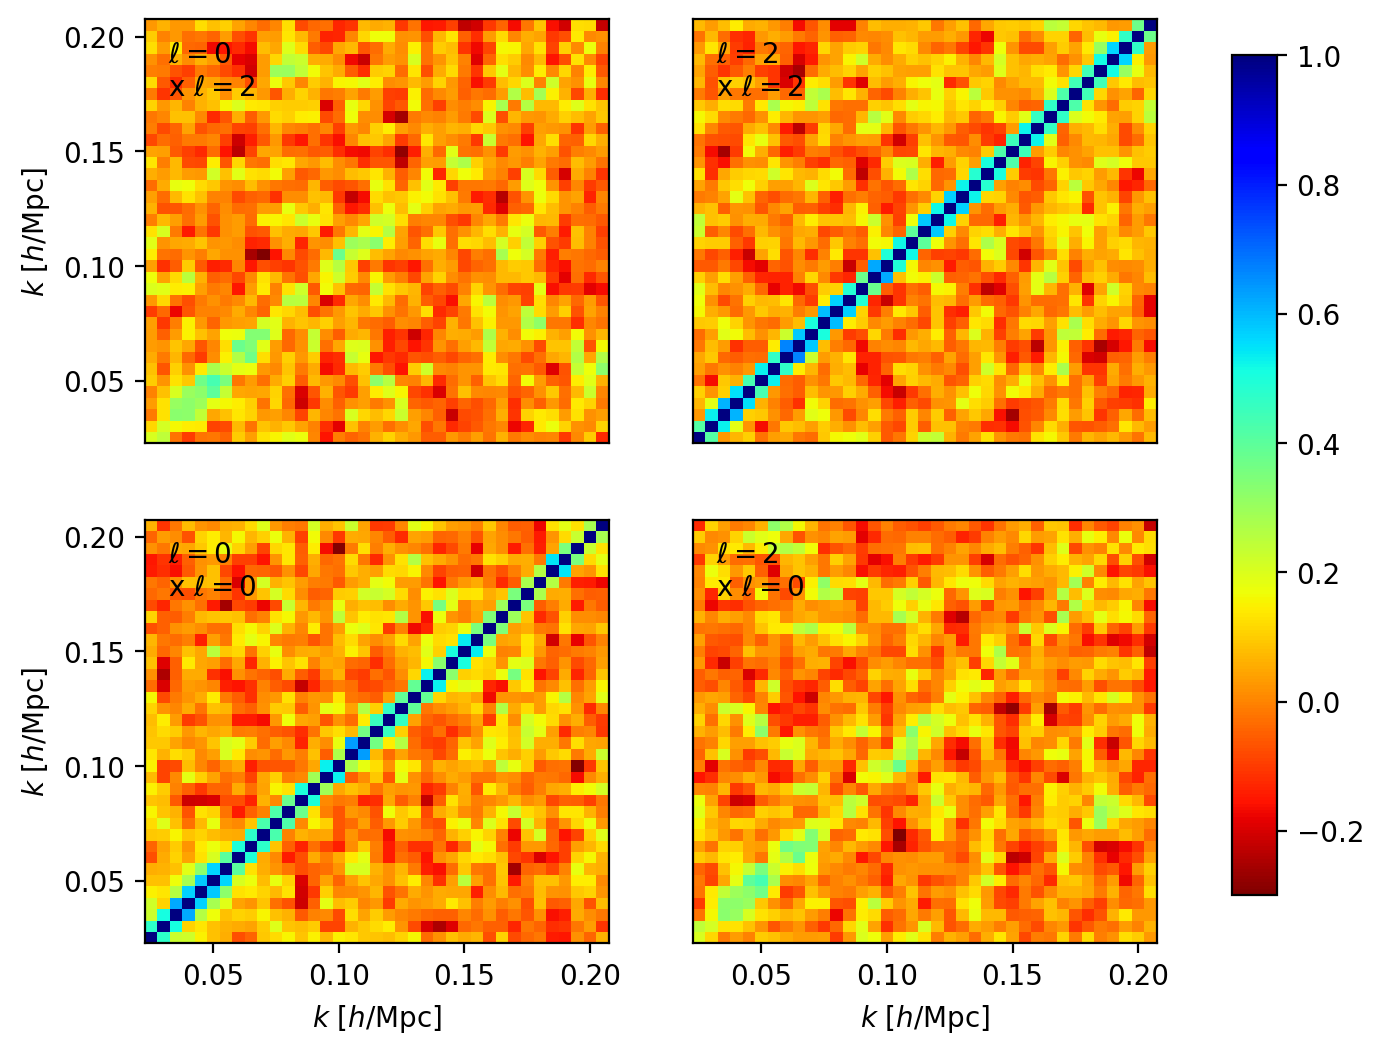

In [4]:
fig_cov = observable.plot_covariance_matrix()

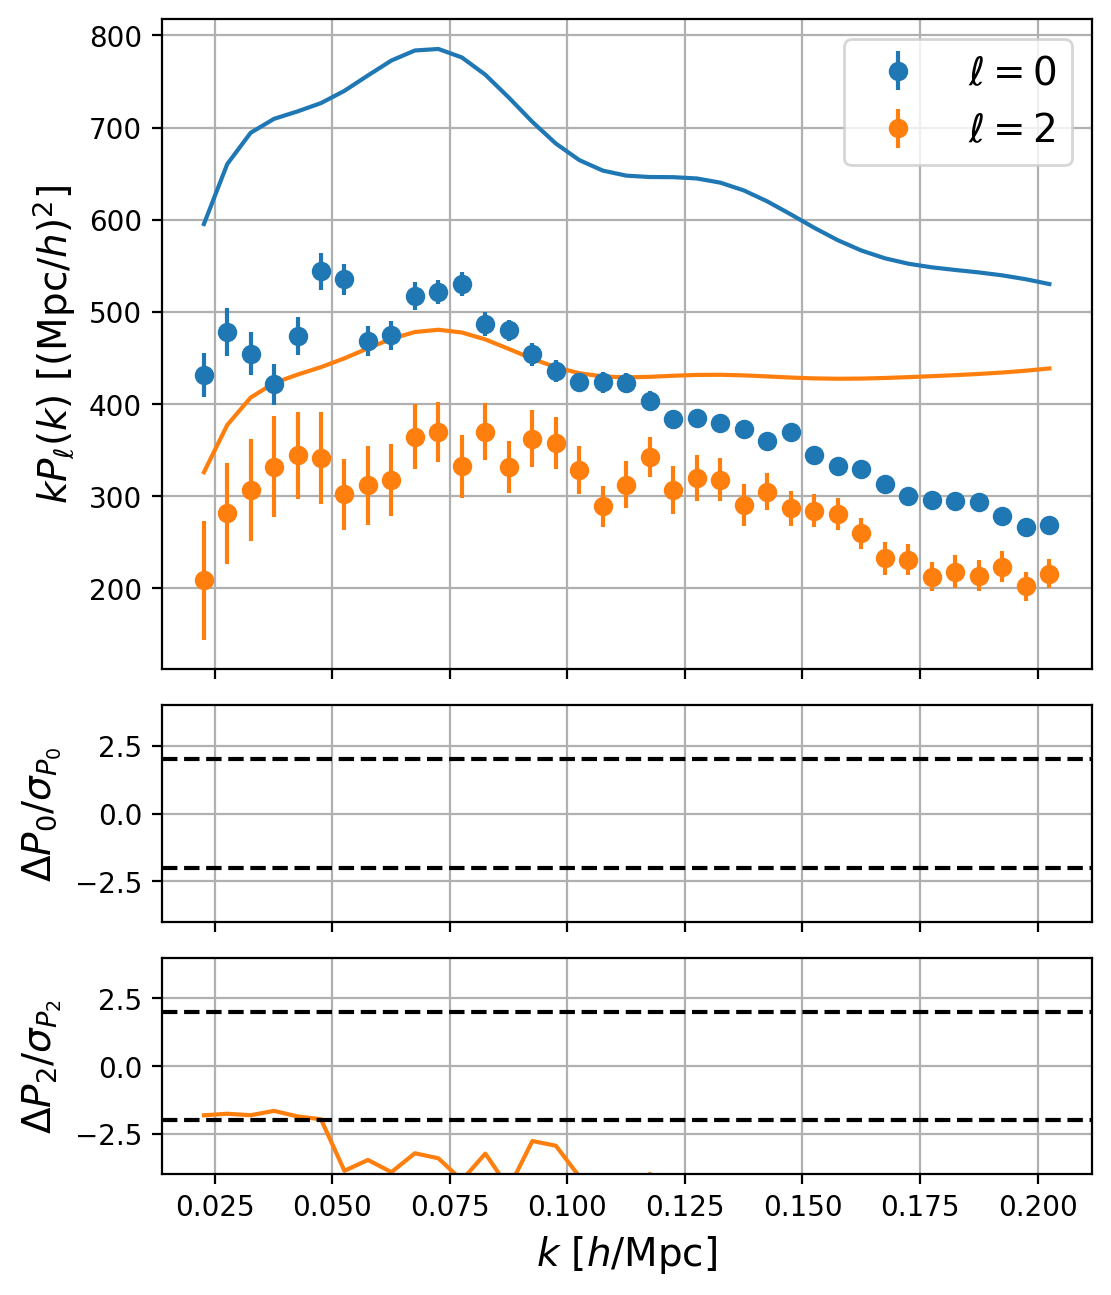

In [5]:
fig_pk = observable.plot()

In [6]:
from desilike.emulators import EmulatedCalculator, Emulator, TaylorEmulatorEngine

cosmology = 'LCDM' #LCDM, nuCDM, wCDM
theory_model = 'FOLPS'  # TNS, FOLPS, FOLPSRC
emulator_fn = f'./results/emulators/emulator_{cosmology}_z{zeff}_{theory_model}.npy'

def initialize_template(redshift, cosmology):
    cosmo = DESI()
    template = DirectPowerSpectrumTemplate(z=redshift, fiducial='DESI')
    if cosmology == 'nuCDM':
        template.init.params['m_ncdm'].update(fixed=False, latex=r'M_\nu', prior = {'limits': [0.0,1.0]})
    elif cosmology == 'nsCDM':
        template.init.params['n_s'].update(fixed=False)
    elif cosmology == 'wCDM':
        template.init.params['w0_fld'].update(fixed=False)
    return template

# os.remove(emulator_fn)
if not os.path.exists(emulator_fn):
    cosmo = DESI()
    template = initialize_template(zeff, cosmology)
    if theory_model =='FOLPS':
        theory = FOLPSTracerPowerSpectrumMultipoles(template=template, k=k_ev)
    elif theory_model =='FOLPSRC':
        theory = FOLPSRCTracerPowerSpectrumMultipoles(template=template, k=k_ev)
    print(theory.varied_params)
    # footprint = BoxFootprint(volume=1e10, nbar=1e-3)
    # covariance = ObservablesCovarianceMatrix(cov_fns, footprints=footprint)()
    observable = TracerPowerSpectrumMultipolesObservable(data= pk_fn, 
                                                        klim=klim, 
                                                        covariance = cov_fns,
                                                        theory = theory,
                                                        kin=np.arange(0.001, 0.35, 0.002),
                                                        wmatrix=wmatrix_fn)
    likelihood = ObservablesGaussianLikelihood(observable)
    likelihood()
    emulator = Emulator(theory.pt, engine=TaylorEmulatorEngine(order=3, method='finite')) # Taylor expansion, up to a given order
    emulator.set_samples() # evaluate the theory derivatives (with jax auto-differentiation if possible, else finite differentiation)
    emulator.fit()
    emulator.save(emulator_fn)
    print("Training emmulator finished")

In [7]:
theory_el = FOLPSTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(emulator_fn), k=k_ev)
print(theory_el(h = 0.7))

[000019.94] [0/1] 10-22 20:10  Emulator                  INFO     Loading ./results/emulators/emulator_LCDM_z0.95_FOLPS.npy.
[[ 5072.76407929 13389.04275556 19662.04110758 24280.61763592
  27569.66429842 29781.25768834 31113.58389813 31730.73536981
  31771.82604072 31356.85333403 30590.18764025 29566.13037591
  28366.62871475 27062.15034758 25711.97180496 24364.05095082
  23056.9266742  21817.93989392 20666.39575324 19614.88447704
  18667.86021011 17824.79102796 17082.20841716 16431.69721058
  15864.62973642 15368.31905707 14932.55069685 14543.40724669
  14189.43248122 13859.1487406  13542.15728194 13229.71014003
  12914.57307802 12591.30561954 12256.12958879 11907.99086029
  11546.29984343 11172.66441798 10790.52483474 10403.28274438
  10015.33475381  9631.451189    9256.18288556  8893.99033324
   8548.6525308   8222.78958177  7919.07162078  7639.73283408
   7384.7060603   7153.33070303  6945.9130508   6761.69397947
   6597.92090034  6452.05187361  6322.26624582  6206.27023747
   6101

In [8]:
from desilike.profilers import MinuitProfiler
from desilike.samples import Profiles

profile_fn = f'./results/profiles/{cosmology}/profiles_{tracer}_{No}_{region}_z{zeff}.npy'   
 
# if os.path.exists(profile_fn): 
#     os.remove(profile_fn)  
if not os.path.exists(profile_fn):
    observable = TracerPowerSpectrumMultipolesObservable(data= pk_fn, 
                                                        klim=klim, 
                                                        covariance = cov_fns,
                                                        theory=theory_el,
                                                        kin=np.arange(0.001, 0.35, 0.002),
                                                        wmatrix=wmatrix_fn)
    likelihood = ObservablesGaussianLikelihood(observable, theory=theory_el)
    likelihood()
    profiler = MinuitProfiler(likelihood, seed=42)
    profiles = profiler.maximize()
    profiles.save(profile_fn)
    print("Profiler finished")
profiles = Profiles.load(profile_fn)
print(profiles.to_stats(tablefmt='pretty'))

[000020.96] [0/1] 10-22 20:11  Profiles                  INFO     Loading ./results/profiles/LCDM/profiles_ELG_LOPnotqso_0_NGC_z0.95.npy.
+--------------------------------------+--------+---------+--------+
| chi2 / (74 - 12) = 29.79 / 62 = 0.48 | varied | bestfit | error  |
+--------------------------------------+--------+---------+--------+
|                  h                   |  True  |  0.742  | 0.033  |
|              omega_cdm               |  True  |  0.085  | 0.011  |
|               omega_b                |  True  | 0.02237 | 3.7e-4 |
|                 logA                 |  True  |  2.009  | 0.051  |
|                  b1                  |  True  |  2.36   |  0.21  |
|                  b2                  |  True  |   5.3   |  1.5   |
|                  bs                  |  True  |  -21.3  |  4.8   |
|                alpha0                |  True  |   360   |  920   |
|                alpha2                |  True  |  -8500  |  8600  |
|                alpha4           

[000068.00] [0/1] 10-22 20:11  TracerPowerSpectrumMultipolesObservable INFO     Loading 1 file ['/pscratch/sd/s/shengyu/altml0/data0/pk/pkpoles_ELG_LOPnotqso_NGC_0.8_1.1_default_FKP_lin_thetacut0.05.npy'].
[000068.02] [0/1] 10-22 20:11  TracerPowerSpectrumMultipolesObservable INFO     Loading 100 files [/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock100/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock120/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock140/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock160/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FK

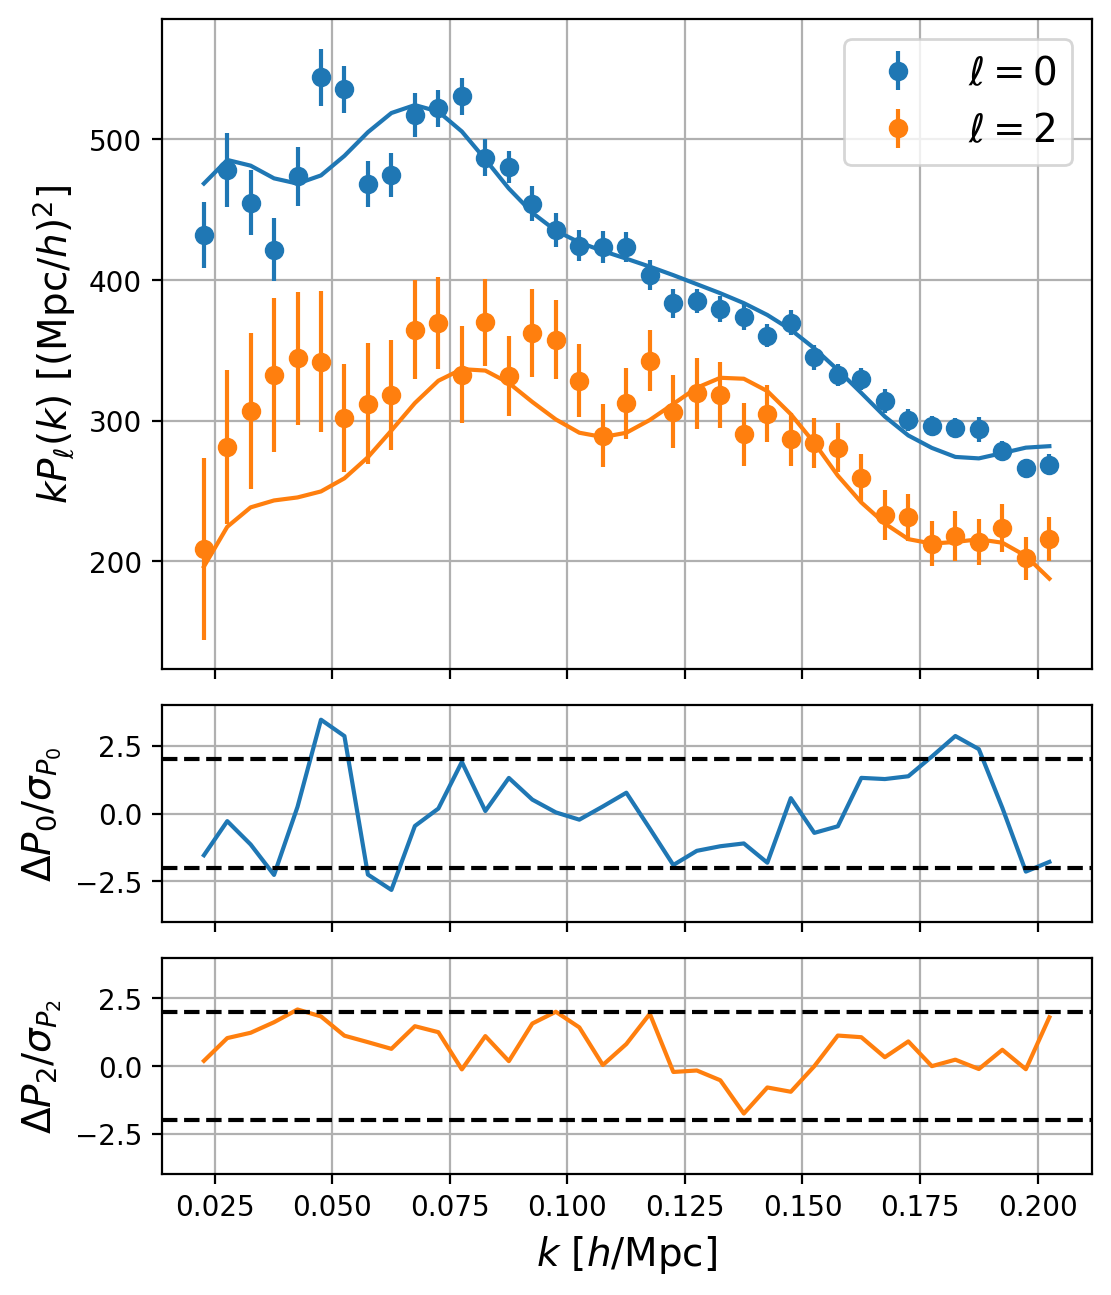

In [11]:
observable = TracerPowerSpectrumMultipolesObservable(data= pk_fn, 
                                                    klim=klim, 
                                                    covariance = cov_fns,
                                                    theory=theory_el,
                                                    kin=np.arange(0.001, 0.35, 0.002),
                                                    wmatrix=wmatrix_fn)
likelihood = ObservablesGaussianLikelihood(observable, theory=theory_el)
print(-2*likelihood(**profiles.bestfit.choice(input=True)))
fig = observable.plot()

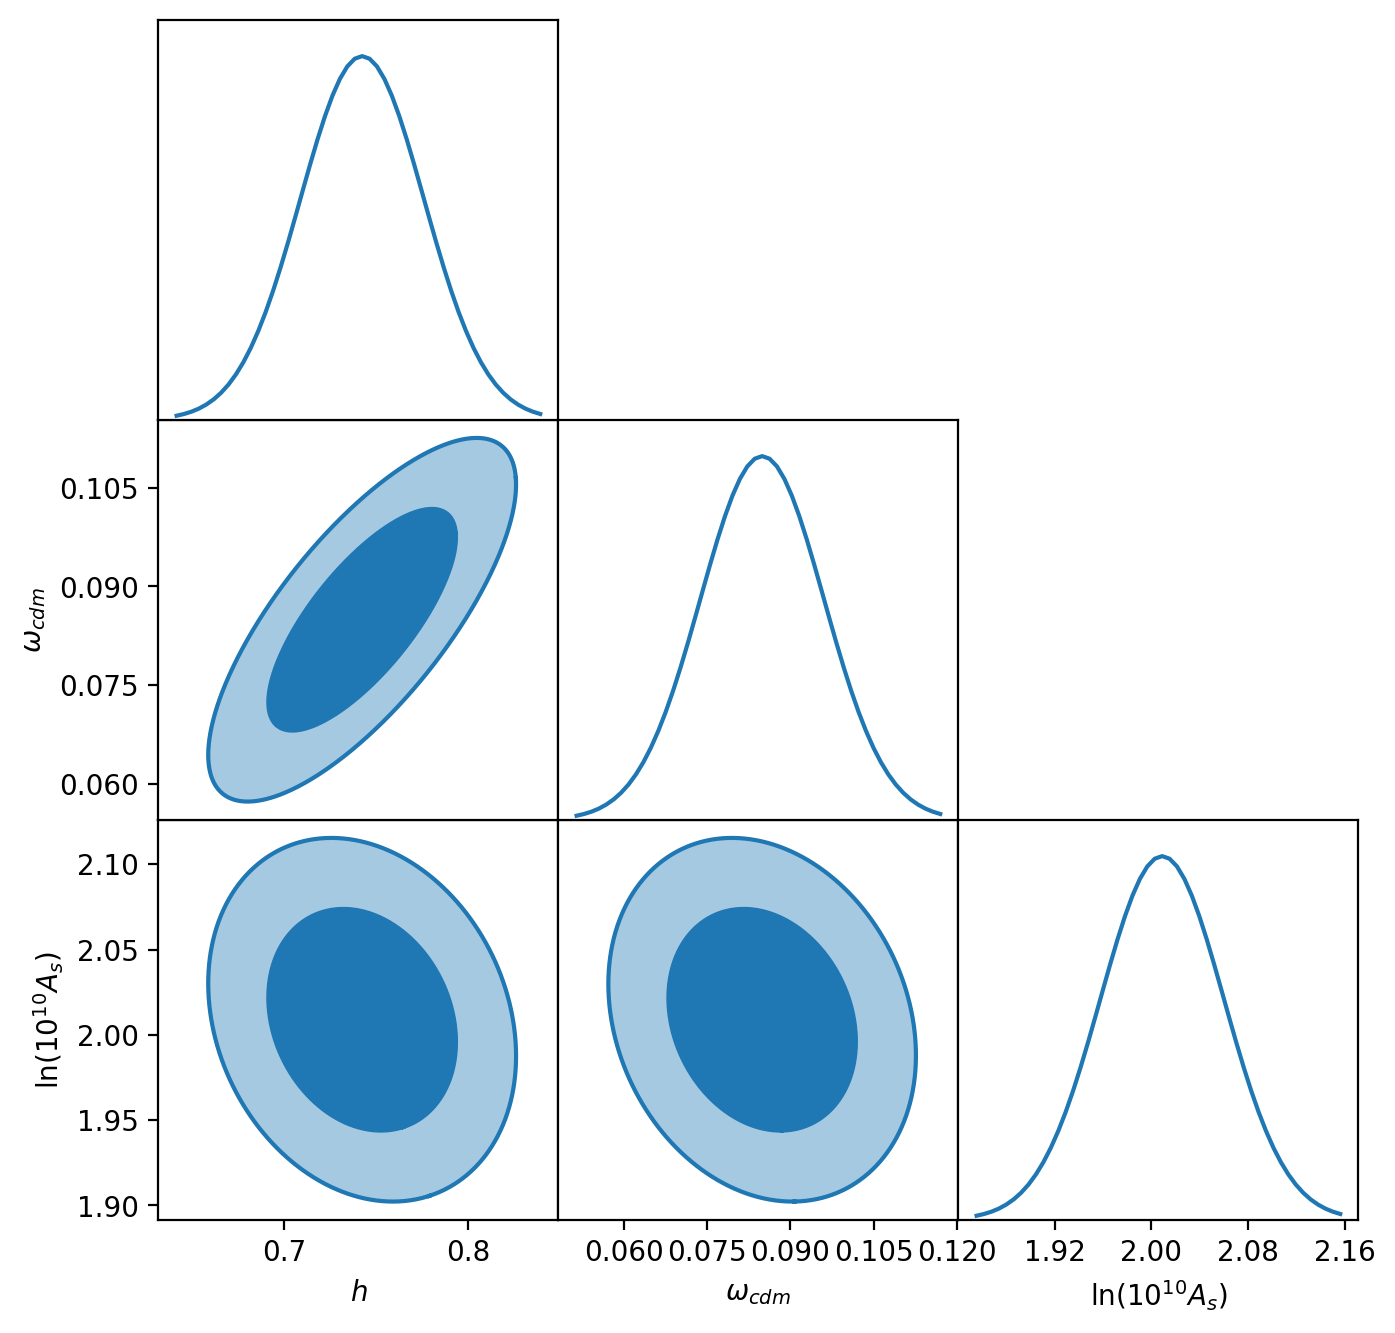

In [12]:
# plot the posterior distribution
from desilike.samples import plotting
fig =plotting.plot_triangle_contours(profiles, params=['h','omega_cdm','logA'], filled=True)